In [1]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# AHBA
import abagen

# Stats
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

In [10]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [6]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in pyspi SPI info 
pyspi_info = pd.read_csv("../feature_extraction/pyspi/pyspi_SPI_info.csv")

### HCP100 ###
HCP100_Pearson_HoFC = (pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
                        .merge(pyspi_info, on="SPI", how="left")
                        .query("SPI=='cov_EmpiricalCovariance' & base_region_to==base_region_from")
                        .dropna(subset=['value'])
                        .rename(columns={"Subject": "Sample_ID", "base_region_to": "base_region"})[['Sample_ID', 'base_region', 'value']]
                        .groupby(['Sample_ID', 'base_region'])['value']
                        .mean()
                        .reset_index()
                        .drop_duplicates()
                        .assign(Diagnosis = "HCP100")
                        )
HCP100_Pearson_HoFC_mean = (HCP100_Pearson_HoFC
                              .groupby(['base_region'])['value']
                                .mean()
                                .reset_index()
                                .rename(columns={"value": "Mean_Pearson_R"})
)

In [8]:
# Load CTIP2 and Satb2 gene expression data if available
if os.path.isfile('../data/Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv'):
    pyramidal_neuron_key_gene_expression_ctx = pd.read_csv('../data/Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv')

else:
    abagen.fetch_microarray(donors='all', verbose=1)

    atlas = abagen.fetch_desikan_killiany()
    atlas_info = pd.read_csv(atlas['info'])
    expression = abagen.get_expression_data(atlas['image'], atlas['info'])

    CTIP2_expression = expression['BCL11B']
    Satb2_expression = expression['SATB2']

    pyramidal_neuron_key_gene_expression_ctx = (pd.DataFrame({'CTIP2': CTIP2_expression.values, 'Satb2': Satb2_expression.values, 
                                                'region': atlas_info.label, 'hemisphere': atlas_info.hemisphere,
                                                'structure': atlas_info.structure})
                                                .query("structure=='cortex'")
                                                .groupby('region')[['CTIP2', 'Satb2']]
                                                .mean()
                                                .reset_index()
                                                .rename(columns={'region': 'base_region'})
    )

    # Write to csv
    pyramidal_neuron_key_gene_expression_ctx.to_csv('../Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv', index=False)

gene_HoFC_merged = HCP100_Pearson_HoFC_mean.merge(pyramidal_neuron_key_gene_expression_ctx, on="base_region")

CTIP2_rho, CTIP2_p = spearmanr(gene_HoFC_merged['Mean_Pearson_R'], gene_HoFC_merged['CTIP2'])
Satb2_rho, Satb2_p = spearmanr(gene_HoFC_merged['Mean_Pearson_R'], gene_HoFC_merged['Satb2'])

print(f"CTIP2: rho={CTIP2_rho:.2f}, p={CTIP2_p:.2e}")
print(f"Satb2: rho={Satb2_rho:.2f}, p={Satb2_p:.2e}")

CTIP2: rho=-0.27, p=1.20e-01
Satb2: rho=0.53, p=1.29e-03


Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi', 'geometry'


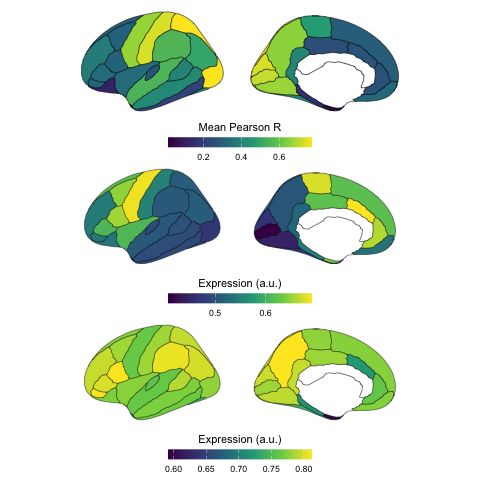

In [11]:
%%R -i pyramidal_neuron_key_gene_expression_ctx,HCP100_Pearson_HoFC_mean

legendwidth <- 2

Pearson_HoFC_brain <- HCP100_Pearson_HoFC_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{base_region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.25) +
  theme_void() +
  labs(fill = "Mean Pearson R") +
  guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
  theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white")

CTIP2_brain <- pyramidal_neuron_key_gene_expression_ctx %>%
      mutate(label = glue("lh_{base_region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = CTIP2),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Expression (a.u.)") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_viridis_c(na.value = "white")

Satb2_brain <- pyramidal_neuron_key_gene_expression_ctx %>%
      mutate(label = glue("lh_{base_region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = Satb2),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Expression (a.u.)") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_viridis_c(na.value = "white")

wrap_plots(list(Pearson_HoFC_brain, CTIP2_brain, Satb2_brain), ncol=1)
# ggsave("../plots/neuromaps_corrs/Layer5_Neuron_Gene_Expression_brainmaps.svg", width=4, height=6, units='in', dpi=300)


ℹ Please use `after_stat(r.label)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



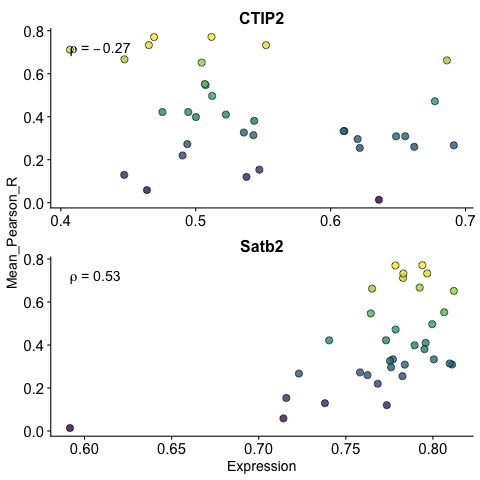

In [12]:
%%R -i gene_HoFC_merged

gene_HoFC_merged %>% 
      pivot_longer(cols=c("CTIP2", "Satb2"), names_to="Gene", values_to="Expression") %>%
      ggplot(data=., mapping=aes(x=Expression, y=Mean_Pearson_R, fill=Mean_Pearson_R)) +
      geom_point(shape=21, color='black', size=3, alpha=0.8) +
      # Facet wrap but repeat axis titles for each facet
      facet_wrap(Gene ~ ., scales="free", ncol=1, axis.labels = 'all') +
      ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
      theme(legend.position='none') +
      scale_fill_viridis_c() +
      theme(strip.background = element_blank(),
            strip.text = element_text(face='bold', size=16),
            axis.text = element_text(size=15))
# ggsave("../plots/neuromaps_corrs/Layer5_Neuron_Gene_Expression_scatters.svg", width=3, height=6, units='in', dpi=300)